Filippo Nardi (100519009)</br>
Jaime Martínez (100451397)

# First optimization practice

### Logistic problem

# so i worked i did some things
The first optimization problem consists in the selection of different offers from some logistic companies to satisfy the demand of a certain board game we manufacture and commercialize

In order to approach the generated problem, it is first necessary to generate the data with the one we will work

We will assume for now that the demand of the board game provided by our factories is fully satisfied, so that we can focus on our problem of selecting the offers that the logistics company provided us so that we can minimize the budget spent in this paragraph

#### But we might enter in dfferent scenarios of not satisfying the demand later</br>

In [17]:
# Imports
# Checking that it works
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [18]:
random.seed(33)
demand = random_numbers = [random.randint(400, 500) for _ in range(52)]
for i in range(43, 52): demand[i] += random.randint(50, 100)
for i in [0, 1]: demand[i] += random.randint(75, 100)

In order to get some feasible demand, which in a real problem it would be given as predictions for the following year, we have used the randint() function for some variation during the weeks, whose output is always the same after having set a seed before. The demand predictions have also been subjected to some increase as we get closer to Christmas weeks, for obvious reasons, since the amount of toys sold during those dates are always greater than during the rest of the year

Since the output is always the same, we thought that it could be better if we gave the possibility of generating a completely random output, which is achieved by the following cell of code when uncommented (we recommend to do so after a first iteration of the problem using the predefined demand)

In [19]:
# # Uncomment all code for random values in demand

# mu, sigma = 500, 25 # mean and standard deviation of the normal used
# weeks = 52 # weeks in a year
# demand = np.random.normal(mu, sigma, weeks)

# counter = 0 # This variable is created to reflect the increasing amount of sales inversely proportional to time left before Christmas
# multiplier = 15 # This value will be the responsible to increase the demand on the previous weeks to Christmas
# for i in range(41, 52):
#     demand[i] += abs(np.random.normal(counter * multiplier, 10)) # We assume a more or less linear increasing in November and December
#     counter += 1
#     
# for i in [0, 1]: demand[i] += np.random.normal(counter * multiplier, 10)
# #print(demand)

# # The following lines of code just converts all values to integers for a more realist approach
# # It also makes sure that no value drops below the lowerbound imposed
# lowerbound = mu - 50
# for i in range(weeks): 
#     if demand[i] < lowerbound: 
#         demand[i] = lowerbound
#     else:
#         demand[i] = int(demand[i])

Then, it would be best if we could visualize the data obtained just to check that the predicted demand is feasible in real world, which in this case, seems that could happen in a real scenario, in where sales increase in November, December and the first weeks of January due to Christmas holidays and keeping the sales more or less stable during the rest of the year

[560, 508, 480, 429, 435, 461, 483, 468, 467, 423, 483, 478, 464, 441, 487, 467, 461, 456, 436, 486, 481, 409, 438, 452, 439, 466, 463, 406, 495, 477, 494, 486, 454, 435, 440, 471, 497, 487, 431, 415, 407, 440, 436, 509, 475, 565, 496, 487, 566, 533, 567, 516]


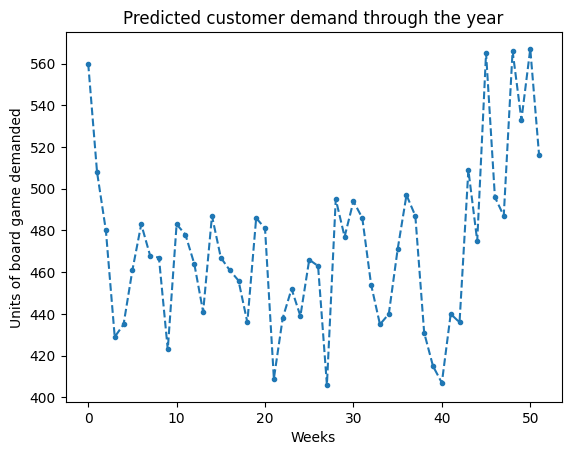

In [20]:
print(demand)
plt.plot(demand, marker = ".", linestyle = "--")
plt.title("Predicted customer demand through the year")
plt.xlabel("Weeks")
plt.ylabel("Units of board game demanded")
plt.show()

In [21]:
"""
Since the demand is now fulfilled and we have checked that the values are more or less feasible, then it is time for knowing the possible offers we could purchase. In order to be able to distribute our manufactured goods throughout Spain, we have contacted three different logistics companies, which have offered us the following traits:

#### Company A: 
- 5 trucks to hire in four consecutive weeks: 350€
- 1 truck to hire in four consecutive weeks: 80€</br>Notice that the consecutive weeks are selected somewhat in multiples of four, which means that we can choose an offer from week 1 to week 4, another one from week 5 to week 8, but we cannot hire a truck to work from week 3 to week 7
- 2 trucks for two consecutive weeks during October or November: 105€
- 2 trucks for two consecutive weeks during December or January: 120€
- 3 trucks for just one week during either December or January: 120€

#### Company B:
- ##### Add more when finished the problem

def consecutiveList(start, stop, weeks):
    auxl = list(np.zeros(weeks))
    for i in range(weeks):
        if i >= start and i < stop:
            auxl[i] = 1
        else:
            auxl[i] = int(auxl[i])
    return auxl
#print(consecutiveList(3, 6, 9))


A = []
for _ in range(weeks):
    A.append(list(np.zeros(weeks)))
print(A)
"""

'\nSince the demand is now fulfilled and we have checked that the values are more or less feasible, then it is time for knowing the possible offers we could purchase. In order to be able to distribute our manufactured goods throughout Spain, we have contacted three different logistics companies, which have offered us the following traits:\n\n#### Company A: \n- 5 trucks to hire in four consecutive weeks: 350€\n- 1 truck to hire in four consecutive weeks: 80€</br>Notice that the consecutive weeks are selected somewhat in multiples of four, which means that we can choose an offer from week 1 to week 4, another one from week 5 to week 8, but we cannot hire a truck to work from week 3 to week 7\n- 2 trucks for two consecutive weeks during October or November: 105€\n- 2 trucks for two consecutive weeks during December or January: 120€\n- 3 trucks for just one week during either December or January: 120€\n\n#### Company B:\n- ##### Add more when finished the problem\n\ndef consecutiveList(st

After having defined our demands numerically, it is now time to distribute the demand throughout a defined map so that we are able to compute the different distances between our factories and the markets we are delivering our goods, which will be equivalent to our costs. Notice that we will use the 40 most populated cities in the United States to define our main markets, and also notice that this number can be changed for a more broad approach. In order to select our factories locations, we will also locate them in cities, despite the fact that we could randomly select some coordinates across the map and select them to be the locations of our factories, but for simplicity we chose not to; also for simplicity, we will remove those instances that 

In order to obtain the distances between these distances, since (unfortunately) the Google Maps API is not free, we opted to compute the distance in a straight line from or factories and destination using a simple Pitagoras Theorem approach using as parameters the latitudes and longitudes of the cities, which might be more or less similar to the real distance between the two points by road. Notice that to do so, we have imported the math package, which allows us to use the function math.dist(), which simplifies things a bit. We have obtained a dataset in where the different cities in the United States and their coordinates appear; they are accompained with their population, which we use to sort our dataset based on it

In [22]:
data = pd.read_csv("us2021census.csv")
data["Longitude"] = data["Longitude"].apply(lambda x: float(x))
data["Latitude"] = data["Latitude"].apply(lambda x: float(x))
df_sorted = data.sort_values(by = "Population", ascending = False)
df = df_sorted[df_sorted["State"].isin(["HI", "AK"]) == False]

In [23]:
n_markets = 40
n_factories = 10
df_markets = df.iloc[0:n_markets]
df_factories = df.iloc[n_markets:n_markets + n_factories]

In [24]:
distances_parameters = []
for idx_f, f in enumerate(df_factories["City"]):
    distances_parameters.append([])
    for idx_m, m in enumerate(df_markets["City"]):
        factory_params = [df.loc[df["City"] == f, "Longitude"].iloc[0], df.loc[df["City"] == f, "Latitude"].iloc[0]]
        market_params = [df.loc[df["City"] == m, "Longitude"].iloc[0], df.loc[df["City"] == m, "Latitude"].iloc[0]]
        distances_parameters[idx_f].append(math.dist(factory_params, market_params))

distances_df = pd.DataFrame(data = distances_parameters, index = df_factories["City"], columns = df_markets["City"])
distances_df


City,New York,Los Angeles,Chicago,Houston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,...,Milwaukee,Albuquerque,Tucson,Fresno,Sacramento,Kansas City,Mesa,Atlanta,Omaha,Colorado Springs
City,,,,,,,,,,,,,,,,,,,,,
Raleigh,6.767553,39.641680,10.864462,17.774492,33.516227,5.429660,20.844032,38.647649,18.403993,43.279980,...,11.772655,28.021645,32.529170,41.161127,42.948174,16.286808,33.276149,6.099095,18.148140,26.360277
Long Beach,44.727633,0.288543,31.622699,23.178164,6.126363,43.470112,20.175426,1.470181,21.417754,5.139380,...,31.675060,11.614795,7.382688,3.371256,5.834629,24.204499,6.370787,33.802005,23.479386,14.296888
Virginia Beach,4.340305,42.361176,12.695948,20.642930,36.259476,3.210849,23.707727,41.397429,21.215877,45.919625,...,13.444388,30.728502,35.303005,43.815133,45.554937,18.745612,36.020679,8.967401,20.448310,28.916350
Miami,16.169658,38.941031,17.741526,15.685899,32.792563,15.043154,18.658296,37.619066,18.022876,43.272236,...,18.912276,28.050093,31.449112,41.086613,43.242771,19.616059,32.548598,9.012426,22.086550,27.877379
Oakland,48.351647,5.504751,34.882195,28.084629,11.088442,47.155947,25.214621,7.208258,25.964499,0.602847,...,34.762891,15.854071,12.601727,2.701632,1.094602,27.718502,11.325057,38.097417,26.556835,17.479256
Minneapolis,19.731026,27.256311,6.436906,15.359993,22.055227,18.792293,16.405927,26.855308,12.695198,29.621479,...,5.705166,16.640188,21.817778,27.767767,28.940528,6.017545,21.865871,14.316351,4.575403,13.082948
Tulsa,22.452149,22.350967,10.137120,6.423771,16.308891,21.170648,7.178990,21.451136,3.466990,25.927003,...,10.622698,10.714461,15.489128,23.805165,25.619930,3.269689,16.074895,11.847465,5.107255,9.228413
Bakersfield,45.327767,1.532063,32.058727,24.312797,7.206847,44.093404,21.373871,3.239902,22.372656,3.478757,...,32.045196,12.370376,8.641002,1.566332,4.049833,24.719192,7.449907,34.667060,23.817998,14.612306
Wichita,23.526673,21.218506,10.577831,8.168360,15.333308,22.289483,8.342918,20.440421,4.934745,24.555494,...,10.847499,9.670626,14.689061,22.471048,24.174425,3.098508,15.109219,13.533317,3.837692,7.571233


In [25]:
print(distances_parameters)


[[6.767553472267499, 39.64168008548578, 10.864461560519235, 17.77449228529468, 33.51622665217551, 5.429660118276275, 20.844031519837998, 38.64764898412322, 18.403993180828994, 43.27997966727804, 19.88328343106339, 6.231583105439582, 18.935351594306358, 6.0428609118529355, 8.51160866111689, 2.272317099350361, 43.82066436055027, 45.27118874074326, 26.643775727175004, 3.5032604813230765, 8.153048018992656, 18.879578199737416, 28.137647396326514, 10.038424428166001, 45.10398786138539, 36.50709391337526, 7.896782129449945, 11.430596003708654, 7.5366738684913335, 4.050883483883486, 11.772654755831418, 28.021644937440776, 32.52917029375327, 41.16112667311234, 42.94817409390066, 16.286807913154746, 33.2761489508627, 6.09909517879497, 18.148140428154065, 26.360276800519383], [44.72763285710523, 0.28854289109246756, 31.622698999294787, 23.17816440100466, 6.126363032011729, 43.470112031141575, 20.175426364763645, 1.470181281339132, 21.417754177317466, 5.139379826399297, 20.74636356087495, 36.6965

Now it is time to define the production rates of the factories. In order to do this, we are selecting just one week (in order to get the demand) and we will also assume that the demand is fulfilled with, at least, the same amount of offer from the factories. This means that the sum of the productions is at least the sum of the demands from all the markets

The way we are doing this is completely based on random data generated, but new functions can be implemented in order to maintain a feasible ral scenario, like obtaining a random measure from a normal distribution with its mean as the total population and then operating and normalizing the whole list of values to fit them proportionally in the demand constraints

In [26]:
s_week = 12 # can be changed
weekly_demand = demand[s_week]
random.seed(33) # this line can be removed for real random outputs

def partitions(number, x):
    partitions = sorted(random.sample(range(number), x - 1))
    partitions = [partitions[0]] + [partitions[i] - partitions[i - 1] for i in range(1, x - 1)] + [number - partitions[-1]]
    return partitions

demand_partitioned = partitions(weekly_demand, len(df_markets["City"]))
production_partitioned = partitions(weekly_demand, len(df_factories["City"]))
print(sum(demand_partitioned) <= sum(production_partitioned))
print(demand_partitioned)
print(production_partitioned)

def generate_dict(l1, l2):
    d = {}
    for idx, i in enumerate(l1):
        d[i] = l2[idx]
    return d

def generate_dist_dict(l_f, l_m, df):
    d = {}
    for i in l_f:
        for e in l_m:
            d[i, e] = df.loc[i, e]
    return d

def cost(model, factory, market): # may add fuel_price/type, discount and/or surcharge/tax
    return model.Distances[factory, market] 

True
[26, 10, 49, 10, 24, 22, 3, 10, 4, 6, 47, 7, 9, 18, 1, 8, 3, 8, 5, 2, 20, 19, 4, 8, 2, 8, 11, 2, 5, 25, 4, 37, 1, 12, 10, 10, 6, 4, 3, 1]
[60, 65, 18, 20, 121, 64, 43, 42, 9, 22]


In [33]:
model = ConcreteModel("Logistics Problem")

model.markets = Set(initialize = list(df_markets["City"]), doc = "Markets")
model.factories = Set(initialize = list(df_factories["City"]), doc = "Factories")
#model.fuel_type = Set(initialize = ("Diesel", "Oil"), doc = "Fuel type")


model.Production = Param(model.factories, initialize = generate_dict(list(df_factories["City"]), production_partitioned), doc = "Factories production")
model.Demand = Param(model.markets, initialize = generate_dict(list(df_markets["City"]), demand_partitioned), doc = "Markets demand")
model.Distances = Param(model.factories, model.markets, initialize = generate_dist_dict(list(df_factories["City"]), list(df_markets["City"]), distances_df), doc = "Distances")
model.Fuel_Price = Param(default = 1.55, doc = "Fuel price")
model.Pallet_Price = Param(default = 4000, doc = "Pallet price")
#model.fuel_price = Param(model.fuel_type, initialize = {'Diesel': float(1.6), 'Oil': float(1.7)}, doc = "Fuel prices")
model.Cost = Param(model.factories, model.markets, initialize = cost, doc = "Cost for the transportation")


6.767553472267499


Define variables

In [ ]:
model.pallets_transported = Var(model.factories, model.markets, doc = 'Pallets transported', within = NonNegativeReals)

Define obj func

In [ ]:
def objective_rule(model):
    return sum(model.Cost[i, j] * model.pallets_transported[i, j] for i in model.factories for j in model.markets)
model.objective = Objective(rule = objective_rule, sense = minimize, doc = 'Transportation cost')



Define constraints

In [ ]:
def check_production(model, factory):
  return sum(model.pallets_transported[factory, market] for market in model.markets) <= model.Production[factory]

model.Constraint_Check_Production = Constraint(model.factories, rule = check_production, doc = 'Production at the factory')
    
def check_demand(model, market):
  return sum(model.pallets_transported[factory, market] for factory in model.factories) >= model.Demand[market]

model.Constraint_Check_Demand = Constraint(model.markets, rule = check_demand, doc = 'Demand at the market' )

In [ ]:
Solver = SolverFactory('gurobi')
Results = Solver.solve(model)

# Display solution
model.pallets_transported.display()


pallets_transported : Pallets transported
    Size=400, Index=pallets_transported_index
    Key                                    : Lower : Value : Upper : Fixed : Stale : Domain
              ('Arlington', 'Albuquerque') :     0 :   0.0 :  None : False : False : NonNegativeReals
                  ('Arlington', 'Atlanta') :     0 :   4.0 :  None : False : False : NonNegativeReals
                   ('Arlington', 'Austin') :     0 :   0.0 :  None : False : False : NonNegativeReals
                ('Arlington', 'Baltimore') :     0 :   0.0 :  None : False : False : NonNegativeReals
                   ('Arlington', 'Boston') :     0 :   0.0 :  None : False : False : NonNegativeReals
                ('Arlington', 'Charlotte') :     0 :   0.0 :  None : False : False : NonNegativeReals
                  ('Arlington', 'Chicago') :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Arlington', 'Colorado Springs') :     0 :   0.0 :  None : False : False : NonNegativeReals
    

Now, create a discrete variable (trucks_used) in order to define the amount of trucks used in a delivery

In [39]:
model.pallets_per_truck = Param(default = 10, doc = "Pallets per truck")
model.trucks_used = Var(model.factories, model.markets, model.pallets_per_truck, doc = "Trucks used") 

def check_benefit(model, factory, market):
  cost = model.Distances[factory, market] * model.Fuel_Price * model.trucks_used
  benefit = model.Demand[market] * model.Pallet_Price
  return # fill in after having defined trucks_used

(type=<class 'pyomo.core.base.param.ScalarParam'>) on block Logistics Problem
with a new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


TypeError: Cannot apply a Set operator to a non-Set ScalarParam component (pallets_per_truck)

#### Possible constraints

1.: It is necessary to select more than ¿3? offers of a certain company to reach an agreement with it (it is not possible to purchase just one or two offers from the same company)

2.: There is a limit of offers provided by the different companies

3.: 

#### Possible first addendum to the optimization problem

We can distribute the different demand along ¿four? cities (Madrid, Barcelona, Sevilla and Bilbao) and we have to minimize the fuel consumption by applying optimization considering our ¿three? factories (Leganés, La Coruña and Zaragoza)

To do so, it would be best to assign an upperbound of goods that a certain factory can manufacture (for example, Leganés can produce up to 50% of the total amount of goods, La Coruña around 30% and Zaragoza around 40%. Notice that the % exceed from suming up 100% so that optimization can be applied). It would also be necessary to get the distance from each factory to each city to compute the fuel consumption (minimize fuel consumption = minimize distance)



###### Possible extra (which we should ask Ricardo to apply it since I dont see it, it is just an idea I got xd): We could maybe select different kinds of trucks to move the goods from factories to destinations, whether they are diesel or petrol (which affect on the price of moving the goods from factories to cities since the different fuels have different pricings). For example, company A provides only diesel trucks, company B only petrol trucks and company C has two offers of diesel and three of petrol trucks